In [1]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
import nibabel as nib
import numpy as np
from skimage.color import gray2rgb
import pandas as pd
import random
from scipy.ndimage import gaussian_filter

In [2]:
class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        self.saved_attention = y
        return x * y.expand_as(x)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.se_block = SEBlock(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def get_attention_weight(self):
        return self.se_block.saved_attention

# Load the pre-built 3D ResNet model
model = r3d_18(pretrained=True, progress=True)

# Replace the first convolution layer for single-channel input
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Replace existing blocks with SEBasicBlock
def make_layer(block, inplanes, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv3d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm3d(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))

    return nn.Sequential(*layers)

# if you want 18 layers, use the following
# model.layer1 = make_layer(SEBasicBlock, 64, 64, 2)
# model.layer2 = make_layer(SEBasicBlock, 64, 128, 2, stride=2)
# model.layer3 = make_layer(SEBasicBlock, 128, 256, 2, stride=2)
# model.layer4 = make_layer(SEBasicBlock, 256, 512, 2, stride=2)

# if you want 9 layers, use the following
model.layer1 = make_layer(SEBasicBlock, 64, 64, 1) 
model.layer2 = make_layer(SEBasicBlock, 64, 128, 1, stride=2)  
model.layer3 = make_layer(SEBasicBlock, 128, 256, 1, stride=2) 
model.layer4 = make_layer(SEBasicBlock, 256, 512, 1, stride=2)  

# Replace the fully connected layer for specific output size
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


C:\Users\duson\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\duson\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [3]:
weights_path = r'D:\Juntao\Code\model_weights_epoch_9.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [92]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
image_data_torch=torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
output = model(image_data_torch)
print(output)

tensor([[ 1.2753, -0.2579, -1.9518]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [4]:
import numpy as np
import torch
from sklearn.linear_model import LinearRegression

def predict(model, data):
    """
    使用模型进行预测的函数。
    """
    data_torch=torch.tensor(data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(data_torch).detach().to('cpu').numpy()

def apply_3d_gaussian_blur_on_region(data, mask, region, sigma=1):
    """
    对三维数据的指定区域应用高斯模糊。
    :param data: 完整的三维 numpy 数组。
    :param mask: 定义区域的掩码。
    :param region: 要模糊的区域的标记。
    :param sigma: 高斯核的标准差。
    :return: 高斯模糊后的完整数据。
    """
    # 创建一个与原始数据形状相同的数组用于存放结果
    result = np.copy(data)

    # 提取感兴趣的区域
    region_data = data[mask == region]

    # 对这个区域应用高斯模糊
    blurred_region = gaussian_filter(region_data, sigma=sigma)

    # 将模糊后的数据放回原始数据集
    result[mask == region] = blurred_region

    return result

def generate_perturbations(data, mask,model,num_samples=50,method='shaded'):
    """
    生成扰动样本。
    """
    num_regions = int(np.max(mask))  # 假设区域编号从1到最大值
    unique_values = np.unique(mask)
    non_zero_regions = [int(value) for value in unique_values if np.count_nonzero(mask == value) > 0]
    print('non zero regions:', len(non_zero_regions))
    Y = []
    X = []

    for i in range(num_samples):
        # 随机选择一半区域进行扰动
        region_to_perturb = random.sample(non_zero_regions, int(len(non_zero_regions)/2))
        result_array = np.ones(num_regions+1, dtype=int)
        for index in region_to_perturb:
            if 0 <= index < len(result_array):
                result_array[index] = 0
        X.append(result_array)

        # 生成扰动
        perturbed_sample = np.copy(data)
        if method=='noise':      # adding noise
            perturbation = np.random.normal(0, 0.1, data.shape)
            for region in region_to_perturb:
                perturbed_sample[mask == region] += np.random.normal(0,0.1,perturbed_sample[mask == region].shape)
        elif method=='occlusion': # remove the certain area
            for region in region_to_perturb:
                perturbed_sample[mask == region] =0
        elif method=='blurring': # Apply 3d gaussian flur
            for region in region_to_perturb:
                apply_3d_gaussian_blur_on_region(perturbed_sample,mask,region)
        elif method== 'inversion':
            for region in region_to_perturb:
                perturbed_sample[mask == region] = 255 - perturbed_sample[mask == region]
                
        Y.append(predict(model,perturbed_sample)[0])

        if i % 10 == 0:
            print(i)
    
    return X, Y

def calculate_inverse_ratios(image):
    image_int = image.astype(int)
    pixel_counts = np.bincount(image_int.ravel(), minlength=78)
    total_pixels = image_int.size
    ratios = pixel_counts / total_pixels
    ratios[ratios == 0] = np.inf
    inverse_ratios = 1 / ratios

    return inverse_ratios.tolist()
    

In [106]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

#for method in ['noise','occlusion','blurring','inversion']:
for method in ['blurring','inversion']:
    X, Y = generate_perturbations(input_data,mask_data,model, 50,method)
    Y=np.array(Y)
    
    regressor0 = LinearRegression()
    regressor1 = LinearRegression()
    regressor2 = LinearRegression()
    regressor0.fit(np.array(X)*v_vector, Y[:,0])
    regressor1.fit(np.array(X)*v_vector, Y[:,1])
    regressor2.fit(np.array(X)*v_vector, Y[:,2])

    pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

# print(regressor0.coef_)
# print(regressor1.coef_)
# print(regressor2.coef_)

# pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40


In [107]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

for method in ['noise','occlusion','blurring','inversion']:
# for method in ['blurring','inversion']:
    X, Y = generate_perturbations(input_data,mask_data,model, 50,method)
    Y=np.array(Y)
    
    regressor0 = LinearRegression()
    regressor1 = LinearRegression()
    regressor2 = LinearRegression()
    regressor0.fit(np.array(X)*v_vector, Y[:,0])
    regressor1.fit(np.array(X)*v_vector, Y[:,1])
    regressor2.fit(np.array(X)*v_vector, Y[:,2])

    pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_%s.csv'%method)

# print(regressor0.coef_)
# print(regressor1.coef_)
# print(regressor2.coef_)

# pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40


In [ ]:
import statsmodels.api as sm
import numpy as np

# X = np.array(X)*v_vector  
# y = Y[:,2]    

# X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

summary_str = model.summary().as_text()

# 使用 Matplotlib 创建图像
fig, ax = plt.subplots(figsize=(10, 20))
# 隐藏实际的坐标轴
ax.axis('off')
# 将摘要作为文本添加到图像上
plt.text(0.01, 0.05, summary_str, {'fontsize': 10}, fontname='monospace')

# 保存图像
plt.savefig(r'D:\Juntao\Data\ANDI3-T1\results\summary.png', dpi=500)

In [ ]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

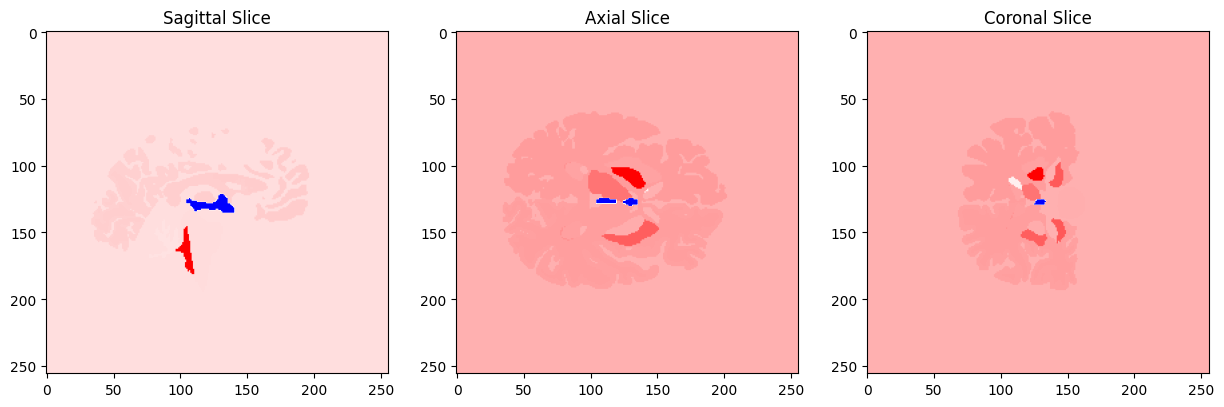

In [99]:
import matplotlib.pyplot as plt

def normalize_11(array,mask):
    unique_values = np.unique(mask)
    non_zero_regions = [int(value) for value in unique_values if np.count_nonzero(mask == value) > 0]
    binary_array = np.zeros(78)
    binary_array[np.array(non_zero_regions) - 1] = 1
    return (2 * (array - array.min()) / (array.max() - array.min()) - 1)*binary_array

def get_interpretation(mri_image,mask,array):
    normalized_array = normalize_11(array,mask)
    for i in range(len(normalized_array)):
        mri_image[mask == i] = normalized_array[i]
    
    return mri_image

mri_image=get_interpretation(input_data,mask_data,regressor2.coef_)

slice1 = mri_image[mri_image.shape[0] // 2, :, :]
slice2 = mri_image[:, mri_image.shape[1] // 2, :]
slice3 = mri_image[:, :, mri_image.shape[2] // 2]

cmap = plt.cm.bwr

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice1, cmap=cmap)
axes[0].set_title('Sagittal Slice')
axes[1].imshow(slice2, cmap=cmap)
axes[1].set_title('Axial Slice')
axes[2].imshow(slice3, cmap=cmap)
axes[2].set_title('Coronal Slice')
plt.show()
fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.png', dpi=300) 

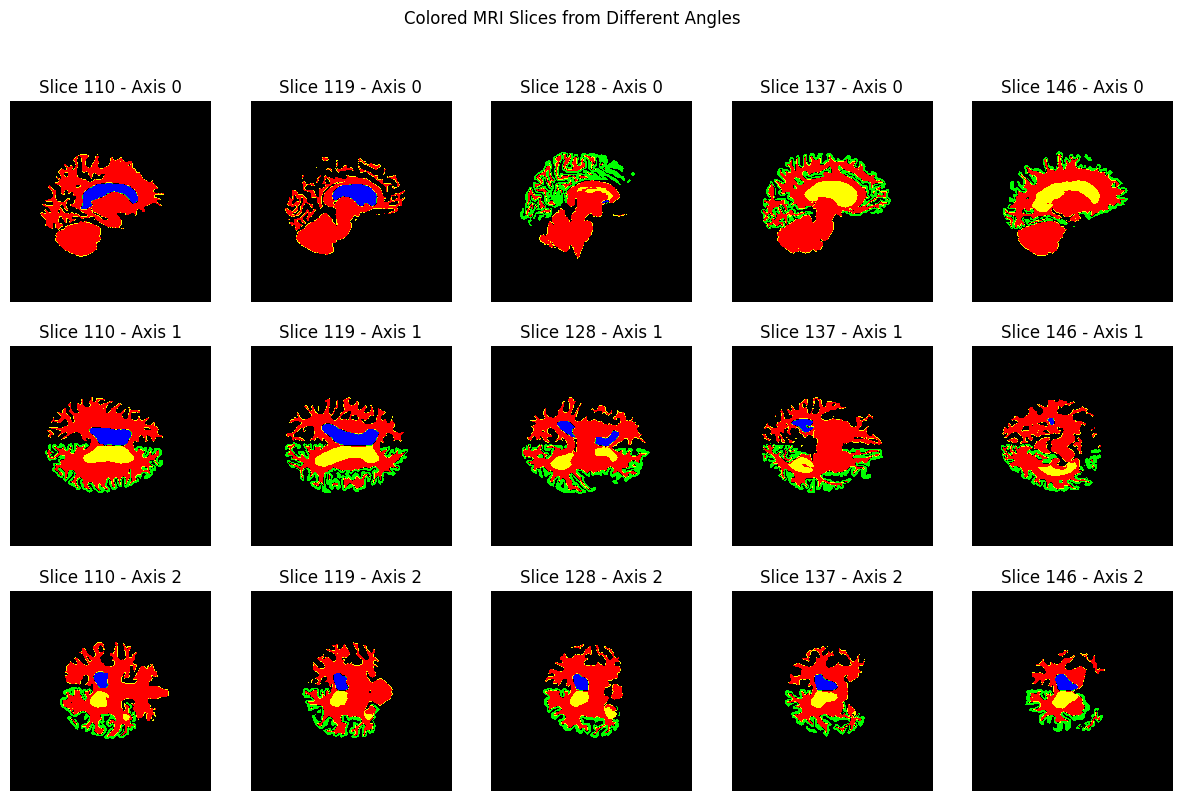

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

mri_image=input_data
mask=mask_data
importance=normalize_11(regressor2.coef_,mask)

# 创建颜色映射
colors = [(0, 0, 1), (0, 1, 0),(0, 0, 0), (1, 1, 0), (1, 0, 0)]  # B, G,black, Y, R
cm = mcolors.LinearSegmentedColormap.from_list('importance_map', colors, N=5)

# 找出绝对值大于0.2的索引
important_indices = np.where(np.abs(importance) > 0.1)[0] + 1

# 创建一个新的图像用于显示
colored_image = np.zeros_like(mri_image, dtype=float)

# 根据mask和重要性为新图像上色
for idx in important_indices:
    mask_idx = mask == idx
    colored_image[mask_idx] = importance[idx - 1]

# 融合原始图像和新图像


# 选择切片位置（靠近中间部分的切片）
slice_positions = np.round(np.linspace(110, 146, 5)).astype(int)  # 靠近中间部分的切片位置

# 画图
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, slice_pos in enumerate(slice_positions):
    # 沿不同方向的切片
    axes[0, i].imshow(colored_image[slice_pos, :, :], cmap=cm, vmin=-1, vmax=1)
    axes[0, i].set_title(f"Slice {slice_pos} - Axis 0")
    axes[0, i].axis('off')

    axes[1, i].imshow(colored_image[:, slice_pos, :], cmap=cm, vmin=-1, vmax=1)
    axes[1, i].set_title(f"Slice {slice_pos} - Axis 1")
    axes[1, i].axis('off')

    axes[2, i].imshow(colored_image[:, :, slice_pos], cmap=cm, vmin=-1, vmax=1)
    axes[2, i].set_title(f"Slice {slice_pos} - Axis 2")
    axes[2, i].axis('off')

fig.suptitle("Colored MRI Slices from Different Angles")
plt.show()

fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion_AD.png', dpi=500) 



In [76]:
colored_image[mask == 70]

array([], dtype=float64)

(array([2.41875e+05, 2.30030e+05, 6.74300e+03, 0.00000e+00, 1.75000e+02,
        0.00000e+00, 1.37350e+04, 0.00000e+00, 4.82510e+04, 0.00000e+00,
        8.00700e+03, 0.00000e+00, 3.40700e+03, 4.59100e+03, 1.97100e+03,
        0.00000e+00, 9.45000e+02, 1.38100e+03, 2.00590e+04, 0.00000e+00,
        4.30900e+03, 1.49600e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.10900e+03,
        0.00000e+00, 0.00000e+00, 5.14000e+02, 0.00000e+00, 4.05700e+03,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 6.73000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.41542e+05, 2.31072e+05, 7.83600e+03,
        0.00000e+00, 1.47000e+02, 0.00000e+00, 1.35420e+04, 0.00000e+00,
        4.87490e+04, 0.00000e+00, 7.81100e+03, 0.00000e+00, 3.56300e+03,
        4.54600e+03, 1.81800e+03, 0.00000e+00, 4.27

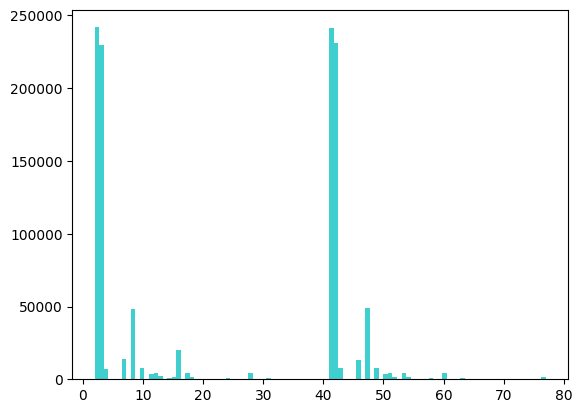

In [84]:
plt.hist(mask[mask>0].ravel(), bins=100, color='c', alpha=0.75)

([<matplotlib.axis.XTick at 0x1f958900550>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '')])

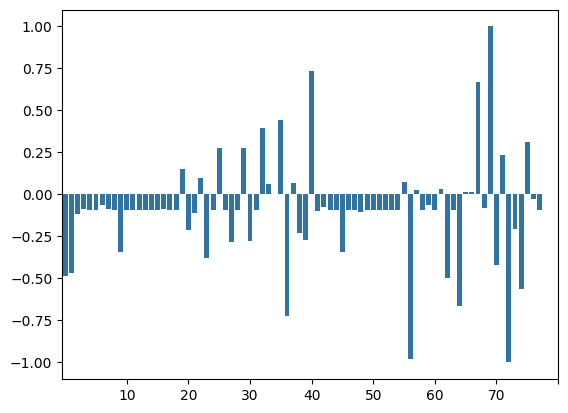

In [85]:
import seaborn as sns
sns.barplot(normalize_11(regressor0.coef_))
plt.xticks(np.arange(10, 81, 10))

([<matplotlib.axis.XTick at 0x1f598e24e20>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '')])

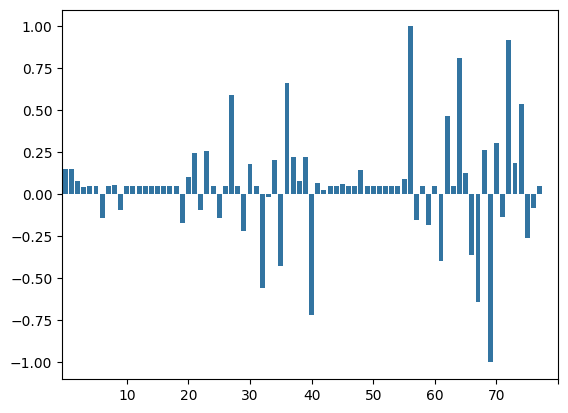

In [86]:
sns.barplot(normalize_11(regressor2.coef_))
plt.xticks(np.arange(10, 81, 10))

### Trasfer weight vector to a DataFrame with the region mapping.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
mapping=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\brain_structures.csv')
df_inversion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion.csv').iloc[2:3,1:].T
df_inversion=-df_inversion
# df_blurring=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_blurring.csv').iloc[2:3,1:].T
df_noise=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.csv').iloc[2:3,1:].T
df_occlusion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_occlusion.csv').iloc[2:3,1:].T
df_att1=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT1.csv').iloc[:,2:3]
df_att2=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT2.csv').iloc[:,2:3]
df_att3=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT3.csv').iloc[:,2:3]
df_att4=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT4.csv').iloc[:,2:3]

df=pd.concat([mapping,df_inversion.reset_index(drop=True)
                  # ,df_blurring.reset_index(drop=True)
                  ,df_noise.reset_index(drop=True)
                  ,df_occlusion.reset_index(drop=True)
                 ,df_att1.reset_index(drop=True)
                 ,df_att2.reset_index(drop=True)
                 ,df_att3.reset_index(drop=True)
                 ,df_att4.reset_index(drop=True)
                 ],axis=1,ignore_index=True)

df.columns=['Region','Fastsurfer','Freefurfer','Group','inversion','noise','occlusion','attention1','attention2','attention3','attention4']

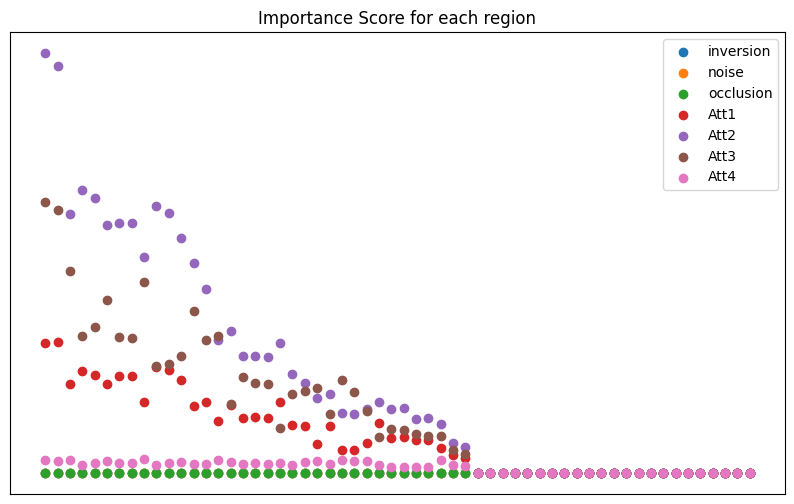

12                   Hippocampus (lh)
51                 pericalcarine (lh)
11                         Brain Stem
27                   Hippocampus (rh)
59          superiorparietal (lh, rh)
50          parstriangularis (lh, rh)
1              Lateral Ventricle (lh)
40              isthmuscingulate (lh)
76                     precuneus (rh)
45            middletemporal (lh, rh)
6                        Caudate (lh)
15                     Accumbens (lh)
43                       lingual (lh)
4              Cerebellar Cortex (lh)
49             parsorbitalis (lh, rh)
48           parsopercularis (lh, rh)
16                    Ventral DC (lh)
10                      4th-Ventricle
52                   postcentral (lh)
9                       3rd-Ventricle
53            posteriorcingulate (lh)
17                Choroid Plexus (lh)
62        transversetemporal (lh, rh)
57      rostralmiddlefrontal (lh, rh)
42          lateralorbitofrontal (lh)
3        Cerebellar White Matter (lh)
30          

In [17]:
df['Average'] = df[['inversion', 'noise', 'occlusion','attention1','attention2','attention3','attention4']].mean(axis=1)

df_filtered = df[df['Average'] != 0].sort_values(by='Average', ascending=False)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Region'], df_filtered['inversion'], label='inversion')
plt.scatter(df_filtered['Region'], df_filtered['noise'], label='noise')
plt.scatter(df_filtered['Region'], df_filtered['occlusion'], label='occlusion')
plt.scatter(df_filtered['Region'], df_filtered['attention1'], label='Att1')
plt.scatter(df_filtered['Region'], df_filtered['attention2'], label='Att2')
plt.scatter(df_filtered['Region'], df_filtered['attention3'], label='Att3')
plt.scatter(df_filtered['Region'], df_filtered['attention4'], label='Att4')
# plt.xlabel('Region')
# plt.ylabel('Importance Score')
plt.title('Importance Score for each region')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()
print(df_filtered['Region'])

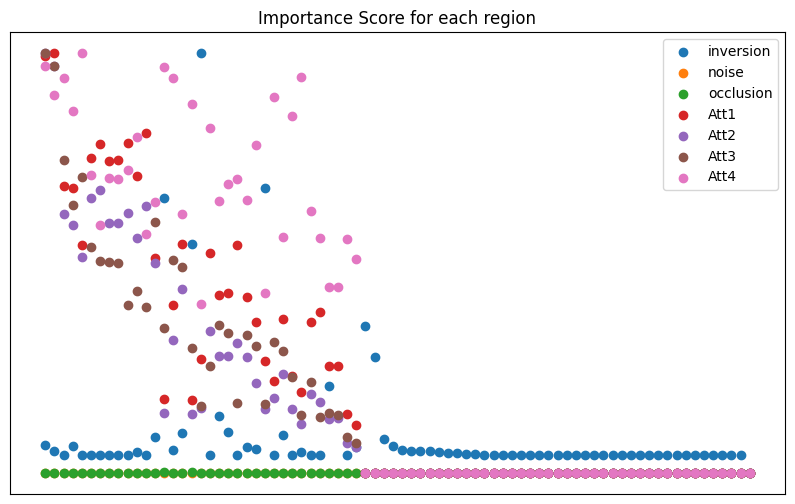

12                   Hippocampus (lh)
51                 pericalcarine (lh)
11                         Brain Stem
50          parstriangularis (lh, rh)
76                     precuneus (rh)
                   ...               
34       caudalmiddlefrontal (lh, rh)
29                     Accumbens (rh)
19             Lateral Ventricle (rh)
20    Inferior Lateral Ventricle (rh)
0          Cortical white matter (lh)
Name: Region, Length: 78, dtype: object


In [20]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['inversion','attention1','attention2','attention3','attention4']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df['Average'] = df[['inversion', 'noise', 'occlusion','attention1','attention2','attention3','attention4']].mean(axis=1)

df_filtered = df[df['Average'] != 0].sort_values(by='Average', ascending=False)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Region'], df_filtered['inversion'], label='inversion')
plt.scatter(df_filtered['Region'], df_filtered['noise'], label='noise')
plt.scatter(df_filtered['Region'], df_filtered['occlusion'], label='occlusion')
plt.scatter(df_filtered['Region'], df_filtered['attention1'], label='Att1')
plt.scatter(df_filtered['Region'], df_filtered['attention2'], label='Att2')
plt.scatter(df_filtered['Region'], df_filtered['attention3'], label='Att3')
plt.scatter(df_filtered['Region'], df_filtered['attention4'], label='Att4')
# plt.xlabel('Region')
# plt.ylabel('Importance Score')
plt.title('Importance Score for each region')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()
print(df_filtered['Region'])

## Attention Visulization

In [4]:
import torch.nn.functional as F

class ModifiedR3D18(nn.Module):
    def __init__(self, original_model):
        super(ModifiedR3D18, self).__init__()
        # 将原始模型的所有层复制过来
        self.stem = original_model.stem
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avgpool = original_model.avgpool
        self.fc = original_model.fc

        # 初始化一个字典来保存特征图
        self.feature_maps = {}
        self.attention_weights = {}
        
    def forward(self, x):
        # 逐层前向传播，同时保存特征图
        x = self.stem(x)
        self.feature_maps['stem'] = x

        x = self.layer1(x)
        self.feature_maps['layer1'] = x

        x = self.layer2(x)
        self.feature_maps['layer2'] = x

        x = self.layer3(x)
        self.feature_maps['layer3'] = x

        x = self.layer4(x)
        self.feature_maps['layer4'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        for name, module in self.named_modules():
            if isinstance(module, SEBasicBlock):
                self.attention_weights[name] = module.get_attention_weight()

        return x


In [5]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()

modified_model = ModifiedR3D18(model).to(device)
output = modified_model(torch.tensor(input_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device))

In [6]:
n=1
feature_maps = modified_model.feature_maps['layer%s'%n]  # 特征图
attention_weights = modified_model.attention_weights['layer%s.0'%n]  # 以此类推

expanded_attention_weights = attention_weights.expand_as(feature_maps)

weighted_feature_maps = feature_maps * expanded_attention_weights

upsampled_feature_maps = F.interpolate(
    weighted_feature_maps,
    size=(256, 256, 256),
    mode='trilinear',
    align_corners=True
)

heatmap = torch.mean(upsampled_feature_maps, dim=1).squeeze()

heatmap = heatmap.cpu().detach().numpy()

results = []
for region_id in range(1, 79):
    region_mask = mask_data == region_id
    average_value = heatmap[region_mask].mean()
    results.append({'Region ID': region_id, 'Average Value': average_value})
df = pd.DataFrame(results)

df_sorted = df.sort_values(by='Region ID')
df_sorted.fillna(0).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT%s.csv'%n)
print('Done')

C:\Users\duson\AppData\Local\Temp\ipykernel_3840\2275939168.py:22: RuntimeWarning: Mean of empty slice.
  average_value = heatmap[region_mask].mean()
C:\Users\duson\.conda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Done


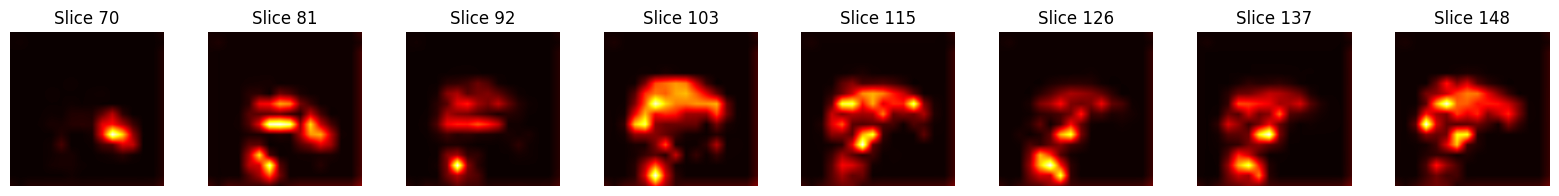

In [7]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8

slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(heatmap[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()
fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_attlayer4.png', dpi=500) 

In [9]:
attention_results=pd.DataFrame()
for i in range(1,5):
    feature_maps = modified_model.feature_maps['layer%s'%i]  # 特征图
    attention_weights = modified_model.attention_weights['layer%s.0'%i]  # 以此类推
    
    expanded_attention_weights = attention_weights.expand_as(feature_maps)
    
    weighted_feature_maps = feature_maps * expanded_attention_weights
    
    upsampled_feature_maps = F.interpolate(
        weighted_feature_maps,
        size=(256, 256, 256),
        mode='trilinear',
        align_corners=True
    )
    heatmap = torch.mean(upsampled_feature_maps, dim=1).squeeze()
    heatmap = heatmap.cpu().detach().numpy()
    
    results = []
    for region_id in range(1, 79):
        region_mask = mask_data == region_id
        average_value = heatmap[region_mask].mean()
        results.append({'Region ID': region_id, 'Average Value': average_value})
    df = pd.DataFrame(results)
    
    df_sorted = df.sort_values(by='Region ID')
    attention_results=pd.concat([attention_results,df_sorted.fillna(0)])
print('Done')

C:\Users\duson\AppData\Local\Temp\ipykernel_18528\2347470649.py:22: RuntimeWarning: Mean of empty slice.
  average_value = heatmap[region_mask].mean()
C:\Users\duson\.conda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 GiB. GPU 0 has a total capacty of 23.99 GiB of which 0 bytes is free. Of the allocated memory 25.11 GiB is allocated by PyTorch, and 205.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Visualize the model

In [ ]:
from torchsummary import summary

summary(model,(1,256,256,256),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 256, 128, 128]           9,408
       BatchNorm3d-2    [-1, 64, 256, 128, 128]             128
              ReLU-3    [-1, 64, 256, 128, 128]               0
            Conv3d-4    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-5    [-1, 64, 256, 128, 128]             128
              ReLU-6    [-1, 64, 256, 128, 128]               0
            Conv3d-7    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-8    [-1, 64, 256, 128, 128]             128
 AdaptiveAvgPool3d-9          [-1, 64, 1, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
          SEBlock-14    [-1, 64, 256, 1

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


### GradCam

In [ ]:
def save_features(module, input, output):
    module.saved_features = output
def save_gradients(module, input, output):
    module.saved_gradients = input[0]
# 假设 target_layer 是您选择进行可视化的层
target_layer = model.layer4[0]  # 例如，选择 model.layer4 的第一个子模块

# 注册钩子
target_layer.register_forward_hook(save_features)
target_layer.register_backward_hook(save_gradients)


In [ ]:
# 前向传播
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device) # 您的输入张量，形状为 [1, C, D, H, W]
input_tensor.requires_grad_(True)

# 如果模型在评估模式下，切换到训练模式
model.eval()

# 执行前向传播
output = model(input_tensor)

# 获取目标类别的输出
target_class = 0 # 目标类别的索引
target = output[0, target_class]

# 反向传播以获取目标类别相对于目标层输出的梯度
model.zero_grad()
target.backward()

In [ ]:
features = target_layer.saved_features
gradients = target_layer.saved_gradients
print(features.shape)
print(gradients.shape)

In [ ]:
# 获取特征图和梯度
features = features[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]
gradients = gradients[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]

# 计算每个通道的权重（全局平均池化）
weights = torch.mean(gradients, dim=[1, 2, 3])  # 在空间维度上计算平均值

# 生成热力图
gcam = torch.zeros_like(features[0]).to(device)  # 初始化热力图
for i, w in enumerate(weights):
    gcam += w * features[i]

# ReLU on top of the heatmap
gcam = F.relu(gcam)

# 热力图归一化处理
gcam -= gcam.min()
gcam /= gcam.max()

# 上采样到原始图像的大小
# 假设原始图像的大小是 [D, H, W]，您需要将这个尺寸提供给代码
original_size = (256, 256, 256)  # 替换为您的原始尺寸
gcam = F.interpolate(gcam.unsqueeze(0).unsqueeze(0), size=original_size, mode='trilinear', align_corners=False).squeeze()

# 现在 gcam 是一个 [D, H, W] 形状的3D热力图


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8
gcam_np=gcam.cpu().detach().numpy()
slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(gcam_np[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()
